# Elementary spatial filtering

**Author: Uzhva Denis Romanovich**

**Lecturer: Soloviev Igor Pavlovich**

## Linear filtering (box, weighted average)
### Theory

The idea behind filtering is that each pixel of an image is being processed according to its local heighborhood (often including itself).
In this model, a given pixel is usually placed inside a center of an odd-sized "window" (also called "kernel" or "mask"), then the whole set of pixels inside the mask is handled according to some operation, which returns a new value for the pixel in the center.
The operations themselves can be linear or non-linear.
In this section, only linear operations are considered.

Assume the window has size $m \times n$ such that $m = 2a + 1$ and $n = 2b + 1$, where $a, b \in \mathbb{N}$; assume also that the given image has resolution of $M \times N$ pixels.
For the sake of simplicity, it is also assumed that the image has only one channel, since the multiple-channel generalization is simple enough to be performed.
Let $A \in \overline{0, 255}^{M \times N}$ be an $M \times N$ matrix of the image, containing values of intensity of corresponding pixels. 
Let also $\widehat{A} \in \overline{0, 255}^{M + 2a \times N + 2b}$ be a padded $A$, i.e. $\widehat{A}_{i+a, j + a} = A_{i, j}$. 
The padding is a powerful method of solving the problem where a mask can climb over the edges of an image when it scans a border pixel.
There are numerous ways to pad an image, however, zero-padding or constant-padding are the most popular techniques.
Let $w \in \mathbb{R}^{m \times n}$ be a matrix of weights of a linear filter.
Observe that the center coefficient of the filter ($w_{a, b}$, since the indices count from 0) aligns with the center of the mask.
With that being said, a linear filter can be represented as follows:
$$
\begin{equation}
B_{i, j} = \sum_{s = -a}^{a} \sum_{s = -b}^{b} w_{s + a, t + b} A_{i + s, j + t},
\tag{1}
\end{equation}
$$
where $B_{i, j}$ is a resulting matrix of the given image after filtration.

The operation described above is also called a correlation of a filter $w$ with an image $A$ and can be rewritten as follows:
$$
\begin{equation}
w_{i, j} \circledast A_{i, j} = \sum_{s = -a}^{a} \sum_{s = -b}^{b} w_{s + a, t + b} A_{i + s, j + t}.
\tag{2}
\end{equation}
$$

In practice, however, a rotated by 180 degrees variation of $w$ is exploited more often. 
With that in mind, one may obtain a so called "convolution":
$$
\begin{equation}
w_{i, j} * A_{i, j} = \sum_{s = -a}^{a} \sum_{s = -b}^{b} w_{s + a, t + b} A_{i - s, j - t}.
\tag{3}
\end{equation}
$$

Symmetrical filters are often used in order to match correlation and convolution.

A filter $w_{i, j} = \frac{1}{mn} \enspace \forall i \in \overline{0, m-1}, \forall j \in \overline{0, n-1}$ is called a box filter.
Another type of a linear filter is a weighted average filter, where the explicit coefficients are chosen in a way to emphasize some pixels, while reducing the importance of others.
The only rule there is that the coefficients should be normalized: $\sum_{i = 0}^{m-1} \sum_{j = 0}^{n-1} w_{i, j} = 1$.
The types of filters mentioned above are used to perform image smoothing. 

### Code

#### Box filter

In [1]:
import numpy as np


def apply_box(img, ker_size=3):
    h = img.shape[0]
    w = img.shape[1]
    pad_size = (ker_size - 1) // 2
    
    img_new = np.zeros_like(img, dtype=float)
    
    if len(img.shape) == 3:
        channels = img.shape[-1]
        filt = np.full((ker_size, ker_size, channels), 1 / (ker_size * ker_size))
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size, channels))
        img_padded[pad_size:-pad_size, pad_size:-pad_size, :] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size, :]
                for ch in range(channels):
                    img_new[i, j, ch] = np.sum(np.multiply(img_loc[:, :, ch], filt[:, :, ch]))
    else:
        filt = np.full((ker_size, ker_size), 1 / (ker_size * ker_size))
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size))
        img_padded[pad_size:-pad_size, pad_size:-pad_size] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size]
                img_new[i, j] = np.sum(np.multiply(img_loc, filt))
                
    img_new = img_new.astype(np.uint8)
    return img_new

#### Weighted average filter

In [2]:
import numpy as np


def apply_w_av(img, filt):
    h = img.shape[0]
    w = img.shape[1]
    ker_size = filt.shape[0]
    pad_size = (ker_size - 1) // 2
    
    img_new = np.zeros_like(img, dtype=float)
    
    if len(img.shape) == 3:
        channels = img.shape[-1]
        for ch in range(channels):
            filt[:, :, ch] = filt[:, :, ch] / np.sum(filt[:, :, ch])
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size, channels))
        img_padded[pad_size:-pad_size, pad_size:-pad_size, :] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size, :]
                for ch in range(channels):
                    img_new[i, j, ch] = np.sum(np.multiply(img_loc[:, :, ch], filt[:, :, ch]))
    else:
        filt = filt / np.sum(filt)
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size))
        img_padded[pad_size:-pad_size, pad_size:-pad_size] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size]
                img_new[i, j] = np.sum(np.multiply(img_loc, filt))
                
    img_new = img_new.astype(np.uint8)
    return img_new

#### Make gaussian kernel

In [3]:
import numpy as np


def get_gaussian_kernel(ker_size=3):
    kernel = np.zeros((ker_size, ker_size))
    a = (ker_size - 1) // 2
    for i in range(ker_size):
        for j in range(ker_size):
            s = i - a
            t = j - a
            kernel[i, j] = np.exp(-(s*s + t*t) / 2.)
            
    kernel = kernel / np.sum(kernel)
            
    return kernel

### Results

#### Processing + visualization

First of all, we need to load images for the further processing:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# http://pages.cs.wisc.edu/~lizhang/projects/autoexpo/content/text.html
img_1 = Image.open('./text1.png')
# http://pages.cs.wisc.edu/~lizhang/projects/autoexpo/content/text.html
img_2 = Image.open('./text2.png')

In [5]:
# represent the images as tensors
np_1 = np.array(img_1)
np_2 = np.array(img_2)
print('Picture dimensions:')
print(np_1.shape)
print(np_2.shape)

Picture dimensions:
(450, 450, 3)
(450, 450, 3)


Apply box filtering for the 1st image:

In [6]:
np_1_b3 = apply_box(np_1, 3)

In [7]:
np_1_b5 = apply_box(np_1, 5)

In [8]:
np_1_b9 = apply_box(np_1, 9)

1st image before and after the box filtering:

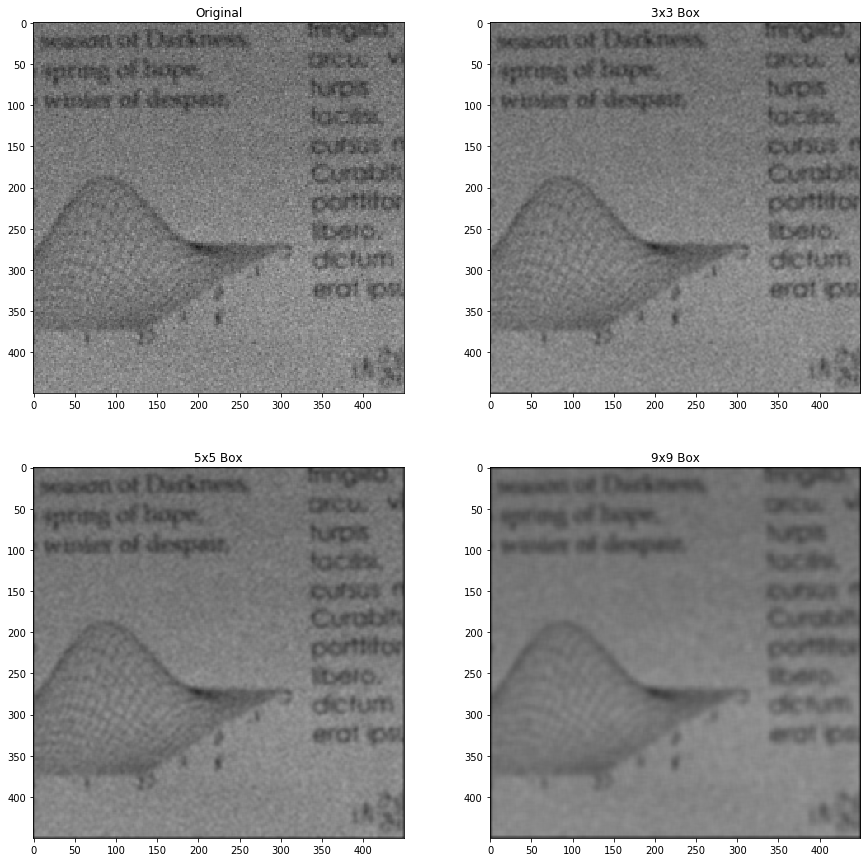

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0, 0].imshow(np_1)
axs[0, 0].set_title('Original')
axs[0, 1].imshow(np_1_b3)
axs[0, 1].set_title('3x3 Box')
axs[1, 0].imshow(np_1_b5)
axs[1, 0].set_title('5x5 Box')
axs[1, 1].imshow(np_1_b9)
axs[1, 1].set_title('9x9 Box')
plt.show()

As it can be seen, the 1st image became more readable after it was smoothened with the box filter. 
The 5x5 kernel bringed the best result. 

Let's try now the weighted average filter, whose weights form the shape of the Gaussian distribution:

In [10]:
# get the kernels
norm3 = np.repeat(get_gaussian_kernel(3).reshape((3, 3, 1)), 3, axis=2)
norm9 = np.repeat(get_gaussian_kernel(9).reshape((9, 9, 1)), 3, axis=2)
norm15 = np.repeat(get_gaussian_kernel(15).reshape((15, 15, 1)), 3, axis=2)

Apply gaussian weighted average filtering for the 1st image:

In [11]:
np_1_w3 = apply_w_av(np_1, norm3)

In [12]:
np_1_w9 = apply_w_av(np_1, norm9)

In [13]:
np_1_w15 = apply_w_av(np_1, norm15)

1st image before and after the weighted average filtering:

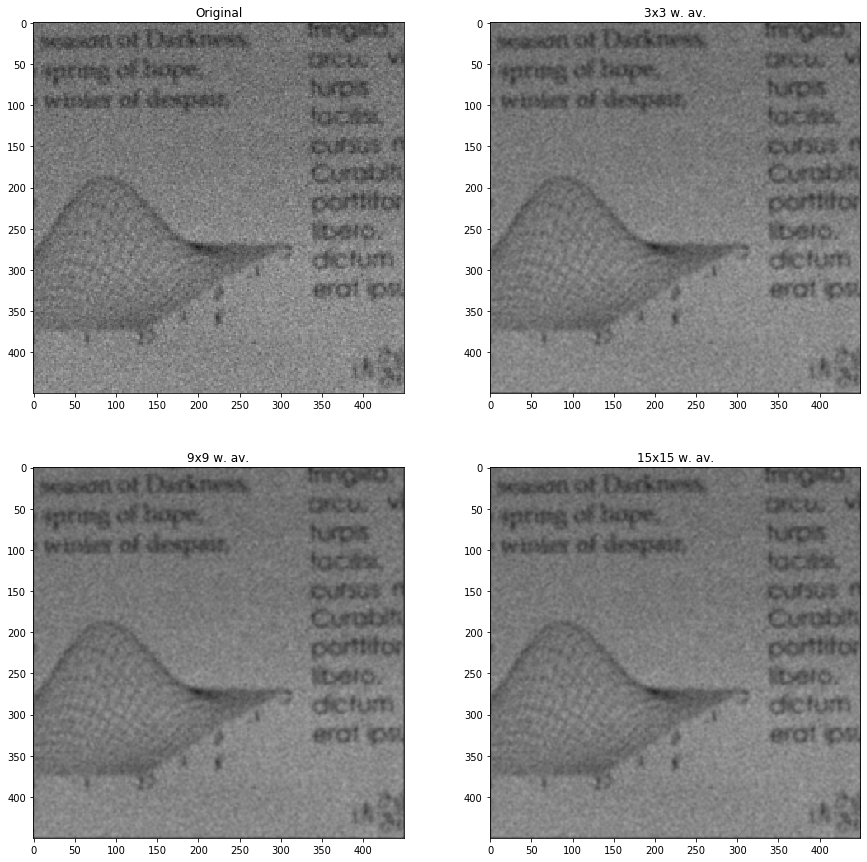

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0, 0].imshow(np_1)
axs[0, 0].set_title('Original')
axs[0, 1].imshow(np_1_w3)
axs[0, 1].set_title('3x3 w. av.')
axs[1, 0].imshow(np_1_w9)
axs[1, 0].set_title('9x9 w. av.')
axs[1, 1].imshow(np_1_w15)
axs[1, 1].set_title('15x15 w. av.')
plt.show()

It is clear that the weighted average filter does not erode the image that badly as the box filter does.
At the same time, it improves readability of the text.

Now let's try to improve the 2nd image:

In [15]:
np_2_b5 = apply_box(np_2, 5)

2nd image before and after the weighted average filtering:

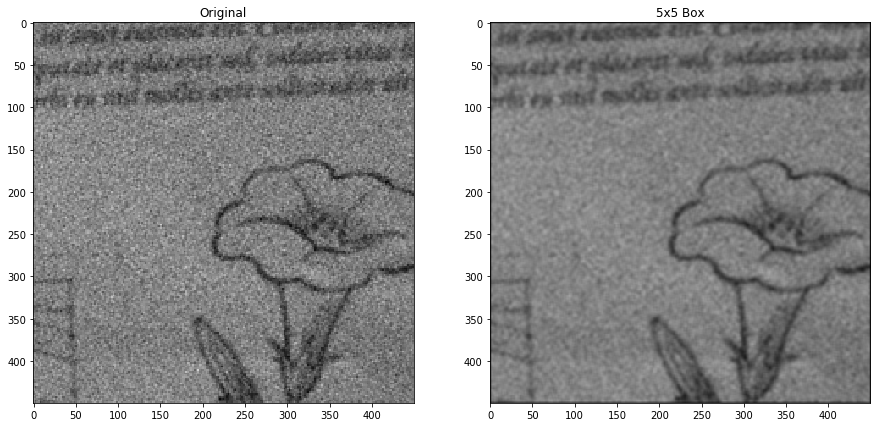

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(np_2)
axs[0].set_title('Original')
axs[1].imshow(np_2_b5)
axs[1].set_title('5x5 Box')
plt.show()

The original image is noised quite badly, however, with the help of the box filter it is now possible to recognize words "et" and "en".

## Nonlinear filtering
### Theory

Nonlinear filters often use order-statistical information about contents of a mask.
For example, one may find a median value among the values of intensity of the pixels inside the kernel.
The median filter is a great solution for the task of image restoration, where some pixels may be missed.

### Code

#### Median filter

In [17]:
import numpy as np


def apply_median(img, ker_size=3):
    h = img.shape[0]
    w = img.shape[1]
    pad_size = (ker_size - 1) // 2
    
    img_new = np.zeros_like(img, dtype=float)
    
    if len(img.shape) == 3:
        channels = img.shape[-1]
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size, channels))
        img_padded[pad_size:-pad_size, pad_size:-pad_size, :] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size, :]
                for ch in range(channels):
                    img_new[i, j, ch] = np.median(img_loc[:, :, ch])
    else:
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size))
        img_padded[pad_size:-pad_size, pad_size:-pad_size] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size]
                img_new[i, j] = np.median(img_loc[:, :])
                
    img_new = img_new.astype(np.uint8)
    return img_new

### Results

#### Processing + visualization

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# From R. Gonzales, R. Woods "Digital Image Processing"
img_21 = Image.open('./sch.tif')
# https://medium.com/@florestony5454/median-filtering-with-python-and-opencv-2bce390be0d1
img_22 = Image.open('./brain.jpeg')

In [19]:
# represent the images as tensors
np_21 = np.array(img_21)
np_22 = np.array(img_22)
print('Picture dimensions:')
print(np_21.shape)
print(np_22.shape)

Picture dimensions:
(440, 455)
(537, 537, 3)


Apply median filtering to the 1st image:

In [20]:
np_21_m3 = apply_median(np_21, 3)

In [21]:
np_21_m5 = apply_median(np_21, 5)

In [22]:
np_21_m9 = apply_median(np_21, 9)

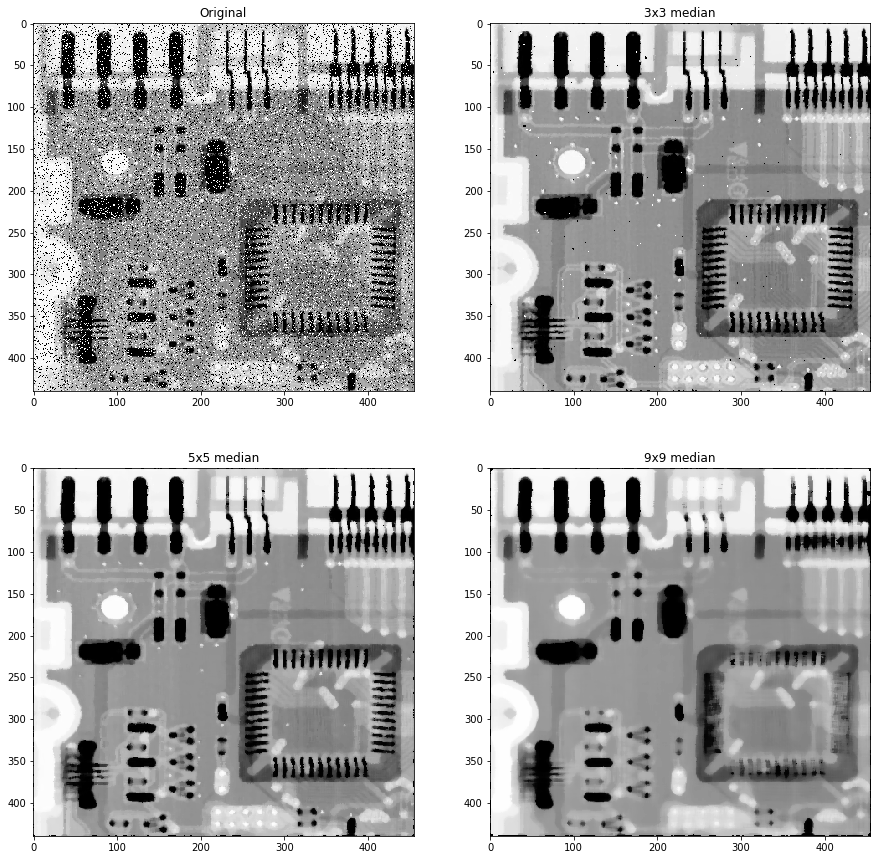

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0, 0].imshow(np_21, cmap='gray')
axs[0, 0].set_title('Original')
axs[0, 1].imshow(np_21_m3, cmap='gray')
axs[0, 1].set_title('3x3 Median')
axs[1, 0].imshow(np_21_m5, cmap='gray')
axs[1, 0].set_title('5x5 Median')
axs[1, 1].imshow(np_21_m9, cmap='gray')
axs[1, 1].set_title('9x9 Median')
plt.show()

The median filter allowed to get rid of the salt noise.

Now let's process the 2nd image:

In [26]:
np_22_m5 = apply_median(np_22, 5)

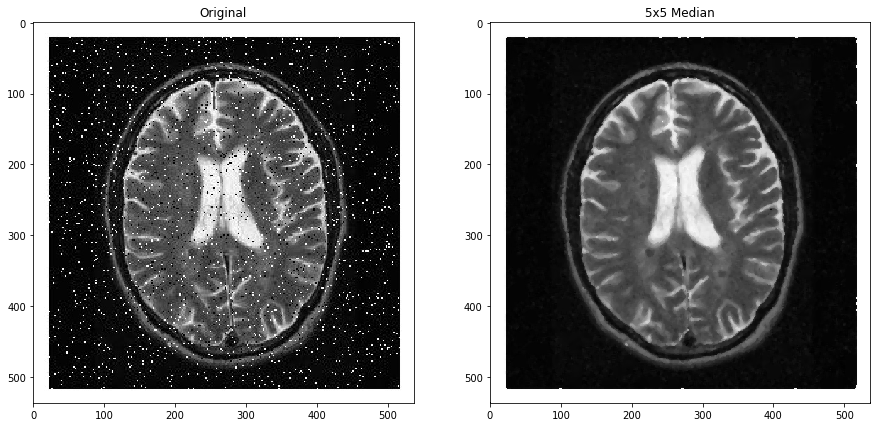

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(np_22)
axs[0].set_title('Original')
axs[1].imshow(np_22_m5)
axs[1].set_title('5x5 Median')
plt.show()

With the help of the median filter with 5x5 mask the brain scan is now cleared from the noise.